# 1 - Introduction


Until now, you've always used Gradient Descent to update the parameters and minimize the cost. In this notebook, you will learn more advanced optimization methods that can speed up learning and perhaps even get you to a better final value for the cost function. Having a good optimization algorithm can be the difference between waiting days vs. just a few hours to get a good result. 

Gradient descent goes "downhill" on a cost function $J$. Think of it as trying to do this: 

<center><img width="600" src="https://drive.google.com/uc?export=view&id=1PLcgmCrlbT_hxUctKYLUlX4qO_V79w5b"></center>
<caption><center> <u> <b>Figure 1</b> </u>: Minimizing the cost is like finding the lowest point in a hilly landscape<br> At each step of the training, you update your parameters following a certain direction to try to get to the lowest possible point. </center></caption>


To get started, run the following code to import the libraries you will need.

# 2 - Import packages

In [1]:
!pip install mlxtend==0.17.3

     |████████████████████████████████| 1.3 MB 419 kB/s eta 0:00:01


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import scipy.io
import time
import datetime
from mlxtend.plotting import plot_decision_regions

%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# 3 - Import the dataset


Lets use the following "moons" dataset to test the different optimization methods. (The dataset is named "moons" because the data from each of the two classes looks a bit like a crescent-shaped moon.) 

In [2]:
def load_dataset():
    np.random.seed(1)
    train_X, train_Y = sklearn.datasets.make_moons(n_samples=300, noise=.2) 
    test_X, test_Y =   sklearn.datasets.make_moons(n_samples=100, noise=.2) 
    # Visualize the data
    plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y.ravel(), s=40, cmap=plt.cm.Spectral);
    train_X = train_X
    train_Y = train_Y.reshape((train_Y.shape[0],1))
    test_X = test_X
    test_Y = test_Y.reshape((test_Y.shape[0],1))
    return train_X, train_Y, test_X, test_Y

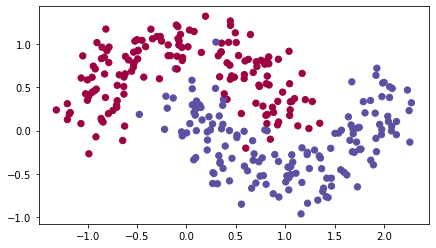

In [3]:
train_x, train_y, test_x, test_y = load_dataset()

In [4]:
print("Shape\nTrain_x: {0} \t Train_y: {1}\nTest_x: {2} \t Test_y: {3}\n".format(train_x.shape,train_y.shape,test_x.shape,test_y.shape))

Shape
Train_x: (300, 2) 	 Train_y: (300, 1)
Test_x: (100, 2) 	 Test_y: (100, 1)



In [5]:
class MyCustomCallback(tf.keras.callbacks.Callback):

  def on_train_begin(self, batch, logs=None):
    self.begins = time.time()
    print('Training: begins at {}'.format(self.begins))

  def on_train_end(self, logs=None):
    print('Duration (seconds) {}'.format(time.time() - self.begins))

In [6]:
def print_analysis(titles,history):
  loss = ["loss", "val_loss"]
  accuracy = ["binary_accuracy","val_binary_accuracy"]
  f, axs = plt.subplots(1,3,figsize=(10,4))
  
  for i,item in enumerate([loss,accuracy]):
    if i == 1:
      axs[i].set_title(titles)
    axs[i].plot(history.history[item[0]])
    axs[i].plot(history.history[item[1]])
    axs[i].set_ylabel(item[0])
    axs[i].set_xlabel('epoch')
    axs[i].legend(['train', 'test'], loc='best')
  
  plot_decision_regions(test_x,test_y.squeeze(), clf=model,zoom_factor=2.0, ax=axs[2])
  plt.tight_layout()
  plt.show()

# 4 - Investigating different optimization methods

## 4.1 Gradient Descent

In [7]:
# Configure the random see for the reproducibility purposes
tf.random.set_seed(3)

# Instantiate a simple classification model
model = tf.keras.Sequential([
                             tf.keras.layers.Dense(5, activation=tf.nn.relu,kernel_initializer="he_uniform"),
                             tf.keras.layers.Dense(2, activation=tf.nn.relu,kernel_initializer="he_uniform"),
                             tf.keras.layers.Dense(1, activation = tf.nn.sigmoid,kernel_initializer="he_uniform")
                             ])

# Instantiate a logistic loss function that expects integer targets (binary classification 0 or 1)
loss = tf.keras.losses.BinaryCrossentropy()

# Instantiate an accuracy metric.
accuracy = tf.keras.metrics.BinaryAccuracy()

# Instantiate an optimizer.
optimizer = tf.keras.optimizers.SGD(learning_rate=0.0007)

# configure the optimizer, loss, and metrics to monitor.
model.compile(optimizer=optimizer, loss=loss, metrics=[accuracy])

# training 
history = model.fit(x=train_x,
                    y=train_y,
                    batch_size=32,
                    epochs=1000,
                    validation_data=(test_x,test_y),
                    callbacks=[MyCustomCallback()],
                    verbose=0)

Training: begins at 1615070182.6440005
Duration (seconds) 28.651764154434204


In [8]:
loss, acc = model.evaluate(x=train_x,y=train_y, batch_size=32)
print('Train loss: %.3f - acc: %.3f' % (loss, acc))

loss_, acc_ = model.evaluate(x=test_x,y=test_y, batch_size=32)
print('Test loss: %.3f - acc: %.3f' % (loss_, acc_))

10/10 [==============================] - 0s 665us/step - loss: 0.4852 - binary_accuracy: 0.8100
Train loss: 0.485 - acc: 0.810
4/4 [==============================] - 0s 931us/step - loss: 0.4813 - binary_accuracy: 0.8000
Test loss: 0.481 - acc: 0.800


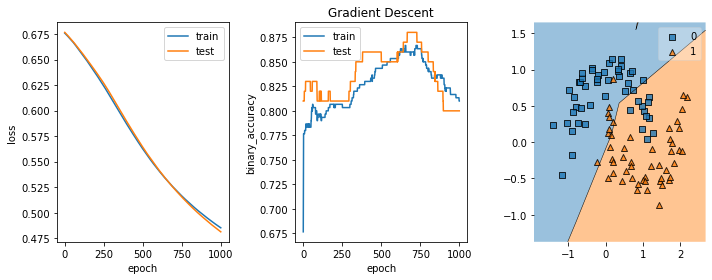

In [9]:
print_analysis("Gradient Descent",history)

## 4.2 Gradient Descent with Momentum

Training a neural network can be made easier with the addition of history to the weight update. Specifically, an exponentially weighted average of the prior updates to the weight can be included when the weights are updated. This change to **stochastic gradient** descent is called **momentum** and adds inertia to the update procedure, causing many past updates in one direction to continue
in that direction in the future.

**Momentum** is set to a value greater than 0.0 and less than one, where **common values such as 0.9 and 0.99** are used in practice.

Momentum does not make it easier to configure the learning rate, as the step size is independent of the momentum. Instead, **momentum can improve the speed of the optimization process** in concert with the step size, improving the likelihood that a better set of weights is discovered in fewer training epochs.

In [10]:
# Configure the random see for the reproducibility purposes
tf.random.set_seed(3)

# Instantiate a simple classification model
model = tf.keras.Sequential([
                             tf.keras.layers.Dense(5, activation=tf.nn.relu,kernel_initializer="he_uniform"),
                             tf.keras.layers.Dense(2, activation=tf.nn.relu,kernel_initializer="he_uniform"),
                             tf.keras.layers.Dense(1, activation = tf.nn.sigmoid,kernel_initializer="he_uniform")
                             ])

# Instantiate a logistic loss function that expects integer targets (binary classification 0 or 1)
loss = tf.keras.losses.BinaryCrossentropy()

# Instantiate an accuracy metric.
accuracy = tf.keras.metrics.BinaryAccuracy()

# Instantiate an optimizer.
optimizer = tf.keras.optimizers.SGD(learning_rate=0.0007,momentum=0.9)

# configure the optimizer, loss, and metrics to monitor.
model.compile(optimizer=optimizer, loss=loss, metrics=[accuracy])

# training 
history = model.fit(x=train_x,
                    y=train_y,
                    batch_size=32,
                    epochs=1000,
                    validation_data=(test_x,test_y),
                    callbacks=[MyCustomCallback()],
                    verbose=0)

Training: begins at 1615070397.9011633
Duration (seconds) 28.328548192977905


In [11]:
loss, acc = model.evaluate(x=train_x,y=train_y, batch_size=32)
print('Train loss: %.3f - acc: %.3f' % (loss, acc))

loss_, acc_ = model.evaluate(x=test_x,y=test_y, batch_size=32)
print('Test loss: %.3f - acc: %.3f' % (loss_, acc_))

10/10 [==============================] - 0s 743us/step - loss: 0.1690 - binary_accuracy: 0.9500
Train loss: 0.169 - acc: 0.950
4/4 [==============================] - 0s 1ms/step - loss: 0.1451 - binary_accuracy: 0.9700
Test loss: 0.145 - acc: 0.970


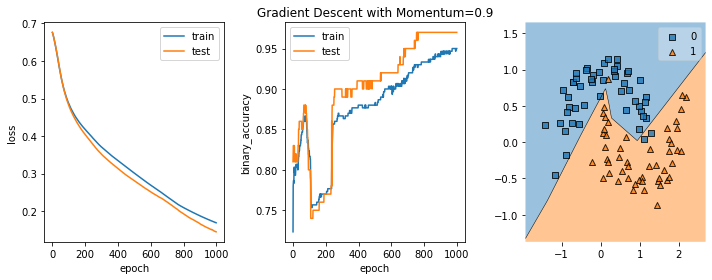

In [12]:
print_analysis("Gradient Descent with Momentum=0.9",history)

<mark><b>Exercise</b></mark>

1. Test the following values for the momentum: 0.5, 0.99, 0.999
2. How many weight values are considered when momentum is configured to 0.9 and 0.99?
3. Configure a weight decay to 0.01. tip: tf.keras.optimizers.SGD(....,decay=0.01). 


**Note regarding Question 3**. With learning rate decay, the learning rate is calculated each update (e.g. end of each mini-batch) as follows:

$
\displaystyle lrate=initial\_lrate \times \frac{1}{1 + decay + iteration}
$

Where *lrate* is the learning rate for the current epoch, *initial lrate* is the learning rate specified as an argument to SGD, *decay* is the decay rate which is greater than zero and iteration is the current update number.

In [32]:
def fit_net(momentum=0.9, decay=0, opt=tf.keras.optimizers.SGD):
    tf.random.set_seed(3)

    # Instantiate a simple classification model
    model = tf.keras.Sequential([
                                 tf.keras.layers.Dense(5, activation=tf.nn.relu,kernel_initializer="he_uniform"),
                                 tf.keras.layers.Dense(2, activation=tf.nn.relu,kernel_initializer="he_uniform"),
                                 tf.keras.layers.Dense(1, activation = tf.nn.sigmoid,kernel_initializer="he_uniform")
                                 ])

    loss = tf.keras.losses.BinaryCrossentropy()

    accuracy = tf.keras.metrics.BinaryAccuracy()

    optimizer = opt(learning_rate=0.0007,momentum=momentum, decay=decay)

    model.compile(optimizer=optimizer, loss=loss, metrics=[accuracy])

    history = model.fit(x=train_x,
                        y=train_y,
                        batch_size=32,
                        epochs=1000,
                        validation_data=(test_x,test_y),
                        callbacks=[MyCustomCallback()],
                        verbose=0)
    
    return [model, history]

**Answer 01: Testing different momentums**

MOMENTUM: 0.5
Training: begins at 1615073671.26193
Duration (seconds) 37.20099759101868
10/10 [==============================] - 0s 676us/step - loss: 0.4171 - binary_accuracy: 0.7700
Train loss: 0.417 - acc: 0.770
4/4 [==============================] - 0s 2ms/step - loss: 0.4039 - binary_accuracy: 0.7700
Test loss: 0.404 - acc: 0.770


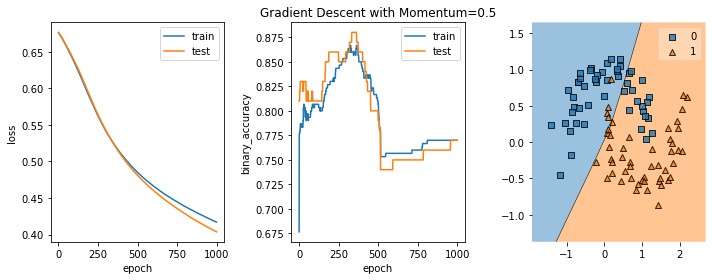

MOMENTUM: 0.99
Training: begins at 1615073710.647867
Duration (seconds) 35.05105376243591
10/10 [==============================] - 0s 731us/step - loss: 0.0672 - binary_accuracy: 0.9733
Train loss: 0.067 - acc: 0.973
4/4 [==============================] - 0s 908us/step - loss: 0.0588 - binary_accuracy: 0.9900
Test loss: 0.059 - acc: 0.990


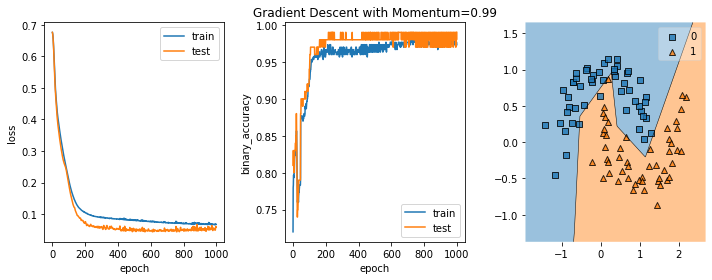

MOMENTUM: 0.999
Training: begins at 1615073747.8513033
Duration (seconds) 35.00482988357544
10/10 [==============================] - 0s 841us/step - loss: 0.0743 - binary_accuracy: 0.9667
Train loss: 0.074 - acc: 0.967
4/4 [==============================] - 0s 2ms/step - loss: 0.1006 - binary_accuracy: 0.9600
Test loss: 0.101 - acc: 0.960


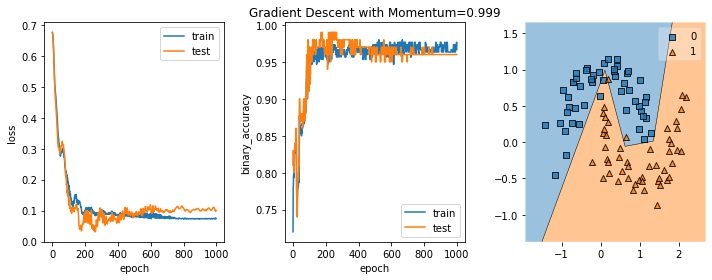

In [33]:
# 1

momentums = [0.5, 0.99, 0.999]

for momentum in momentums:
    print('MOMENTUM: %s' % str(momentum))
    [model, history] = fit_net(momentum=momentum)

    loss, acc = model.evaluate(x=train_x,y=train_y, batch_size=32)
    print('Train loss: %.3f - acc: %.3f' % (loss, acc))

    loss_, acc_ = model.evaluate(x=test_x,y=test_y, batch_size=32)
    print('Test loss: %.3f - acc: %.3f' % (loss_, acc_))
    
    print_analysis("Gradient Descent with Momentum=%s" % str(momentum), history)

**Answer 02: Weight values considered by each momentum configuration**

In [25]:
# 2
for m in [0.9, 0.99]:
    print('Supposing the momentum = %s, %.f weight values are considered.' % (str(m), 1/(1-m)))

Supposing the momentum = 0.9, 10 weight values are considered.
Supposing the momentum = 0.99, 100 weight values are considered.


**Answer 03: Considering a learning rate decay = 0.01**

MOMENTUM: 0.5; DECAY: 0.01
Training: begins at 1615073785.015417
Duration (seconds) 36.20476794242859
10/10 [==============================] - 0s 1ms/step - loss: 0.6593 - binary_accuracy: 0.7900
Train loss: 0.659 - acc: 0.790
4/4 [==============================] - 0s 983us/step - loss: 0.6603 - binary_accuracy: 0.8100
Test loss: 0.660 - acc: 0.810


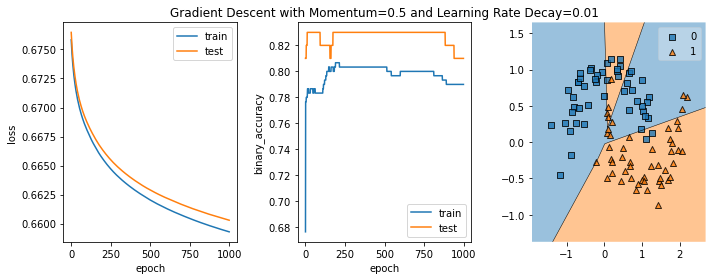

MOMENTUM: 0.99; DECAY: 0.01
Training: begins at 1615073823.382158
Duration (seconds) 35.43128061294556
10/10 [==============================] - 0s 826us/step - loss: 0.3240 - binary_accuracy: 0.8800
Train loss: 0.324 - acc: 0.880
4/4 [==============================] - 0s 976us/step - loss: 0.3013 - binary_accuracy: 0.9100
Test loss: 0.301 - acc: 0.910


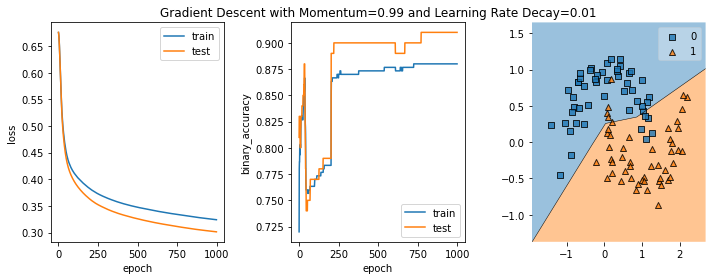

MOMENTUM: 0.999; DECAY: 0.01
Training: begins at 1615073860.9619834
Duration (seconds) 35.41116547584534
10/10 [==============================] - 0s 733us/step - loss: 0.1113 - binary_accuracy: 0.9633
Train loss: 0.111 - acc: 0.963
4/4 [==============================] - 0s 1ms/step - loss: 0.0855 - binary_accuracy: 0.9700
Test loss: 0.085 - acc: 0.970


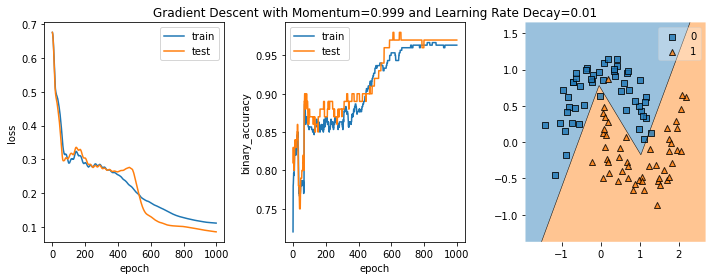

In [34]:
# 3
momentums = [0.5, 0.99, 0.999]

for momentum in momentums:
    print('MOMENTUM: %s; DECAY: 0.01' % str(momentum))
    [model, history] = fit_net(momentum=momentum, decay=0.01)

    loss, acc = model.evaluate(x=train_x,y=train_y, batch_size=32)
    print('Train loss: %.3f - acc: %.3f' % (loss, acc))

    loss_, acc_ = model.evaluate(x=test_x,y=test_y, batch_size=32)
    print('Test loss: %.3f - acc: %.3f' % (loss_, acc_))
    
    print_analysis("Gradient Descent with Momentum=%s and Learning Rate Decay=0.01" % str(momentum), history)

## 4.3 Adaptive Learning Rate Gradient Descent

Keras also provides a suite of extensions of simple stochastic gradient descent that support adaptive learning rates. Because each method adapts the learning rate, often one learning rate per model weight, little configuration is often required. Three commonly used adaptive learning rate methods include:

- Adagrad
- Adam
- RMSprop

For a complete list please see this [link](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers)

<mark>Exercise</mark>

- Use the same model of section 4.2, but now consider change the SGD by Adam or RMSprop.
- Compare the results and try to understanding the differences between different optimization methods.

In [37]:
def fit_net_opt(opt=tf.keras.optimizers.SGD):
    tf.random.set_seed(3)

    # Instantiate a simple classification model
    model = tf.keras.Sequential([
                                 tf.keras.layers.Dense(5, activation=tf.nn.relu,kernel_initializer="he_uniform"),
                                 tf.keras.layers.Dense(2, activation=tf.nn.relu,kernel_initializer="he_uniform"),
                                 tf.keras.layers.Dense(1, activation = tf.nn.sigmoid,kernel_initializer="he_uniform")
                                 ])

    loss = tf.keras.losses.BinaryCrossentropy()

    accuracy = tf.keras.metrics.BinaryAccuracy()

    optimizer = opt(learning_rate=0.0007)

    model.compile(optimizer=optimizer, loss=loss, metrics=[accuracy])

    history = model.fit(x=train_x,
                        y=train_y,
                        batch_size=32,
                        epochs=1000,
                        validation_data=(test_x,test_y),
                        callbacks=[MyCustomCallback()],
                        verbose=0)
    
    return [model, history]


Optimizer: SGD
Training: begins at 1615074703.4032683
Duration (seconds) 37.381144762039185
10/10 [==============================] - 0s 771us/step - loss: 0.4852 - binary_accuracy: 0.8100
Train loss: 0.485 - acc: 0.810
4/4 [==============================] - 0s 1ms/step - loss: 0.4813 - binary_accuracy: 0.8000
Test loss: 0.481 - acc: 0.800


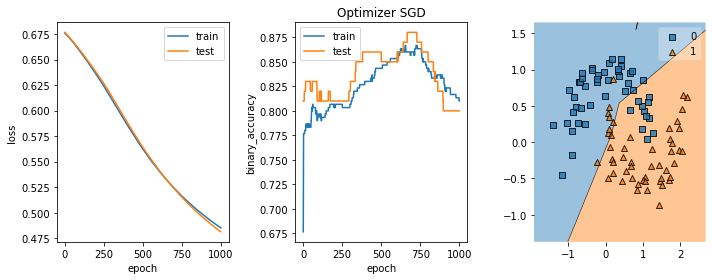


Optimizer: Adam
Training: begins at 1615074743.0053349
Duration (seconds) 38.47737193107605
10/10 [==============================] - 0s 956us/step - loss: 0.0931 - binary_accuracy: 0.9667
Train loss: 0.093 - acc: 0.967
4/4 [==============================] - 0s 1ms/step - loss: 0.0792 - binary_accuracy: 0.9700
Test loss: 0.079 - acc: 0.970


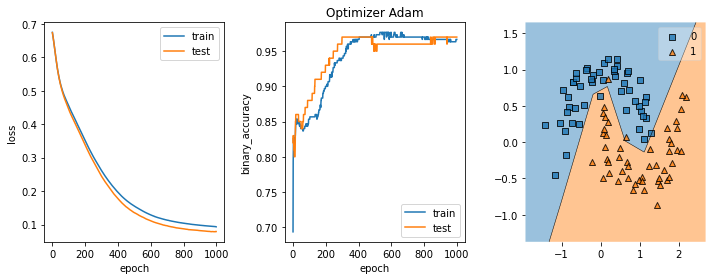


Optimizer: RMSprop
Training: begins at 1615074784.071064
Duration (seconds) 35.83539438247681
10/10 [==============================] - 0s 1ms/step - loss: 0.0904 - binary_accuracy: 0.9667
Train loss: 0.090 - acc: 0.967
4/4 [==============================] - 0s 1ms/step - loss: 0.0751 - binary_accuracy: 0.9600
Test loss: 0.075 - acc: 0.960


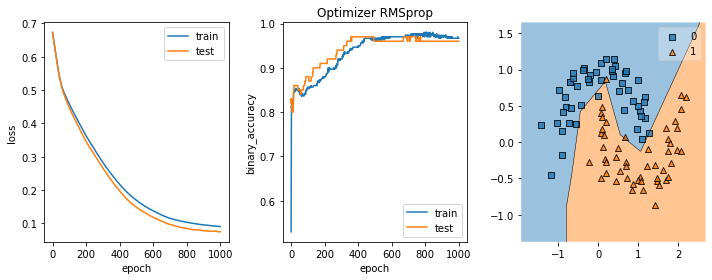

In [38]:
opts = [tf.keras.optimizers.SGD, tf.keras.optimizers.Adam, tf.keras.optimizers.RMSprop]

for opt in opts:
    print('\nOptimizer: %s' % opt.__name__)
    [model, history] = fit_net_opt(opt=opt)

    loss, acc = model.evaluate(x=train_x,y=train_y, batch_size=32)
    print('Train loss: %.3f - acc: %.3f' % (loss, acc))

    loss_, acc_ = model.evaluate(x=test_x,y=test_y, batch_size=32)
    print('Test loss: %.3f - acc: %.3f' % (loss_, acc_))
    
    print_analysis("Optimizer %s" % opt.__name__, history)

# 5 - All Together

## 5.1 Effect of Learning Rate

In [39]:
# fit a model and plot learning curve
def fit_model(label,trainX, trainy, testX, testy, lrate=0.0007, momentum=0.9, decay=0):

    # Configure the random see for the reproducibility purposes
    tf.random.set_seed(3)

    # Instantiate a simple classification model
    model = tf.keras.Sequential([
                                tf.keras.layers.Dense(5, activation=tf.nn.relu,kernel_initializer="he_uniform"),
                                tf.keras.layers.Dense(2, activation=tf.nn.relu,kernel_initializer="he_uniform"),
                                tf.keras.layers.Dense(1, activation = tf.nn.sigmoid,kernel_initializer="he_uniform")
                                ])

    # Instantiate a logistic loss function that expects integer targets (binary classification 0 or 1)
    loss = tf.keras.losses.BinaryCrossentropy()

    # Instantiate an accuracy metric.
    accuracy = tf.keras.metrics.BinaryAccuracy()

    # Instantiate an optimizer.
    optimizer = tf.keras.optimizers.SGD(learning_rate=lrate,momentum=momentum, decay=decay)

    # configure the optimizer, loss, and metrics to monitor.
    model.compile(optimizer=optimizer, loss=loss, metrics=[accuracy])

    # training 
    history = model.fit(x=trainX,
                        y=trainy,
                        batch_size=32,
                        epochs=1000,
                        validation_data=(testX,testy),
                        callbacks=[MyCustomCallback()],
                        verbose=0)

    plt.plot(history.history['binary_accuracy'], label='train')
    plt.plot(history.history['val_binary_accuracy'], label='test')
    if label == "lrate":
      plt.title(label+'='+str(lrate), pad=-50)
    elif label == "momentum":
      plt.title(label+'='+str(momentum), pad=-50)
    else:
      plt.title(label+'='+str(decay), pad=-50)

Training: begins at 1614914006.9172792
Duration (seconds) 36.07037973403931
Training: begins at 1614914043.0392334
Duration (seconds) 35.26998448371887
Training: begins at 1614914078.3550713
Duration (seconds) 35.546924114227295
Training: begins at 1614914113.9464443
Duration (seconds) 34.50413751602173
Training: begins at 1614914148.4948726
Duration (seconds) 34.49744629859924
Training: begins at 1614914183.0365913
Duration (seconds) 34.28663516044617
Training: begins at 1614914217.3674595
Duration (seconds) 35.88140821456909
Training: begins at 1614914253.2935271
Duration (seconds) 35.74034070968628


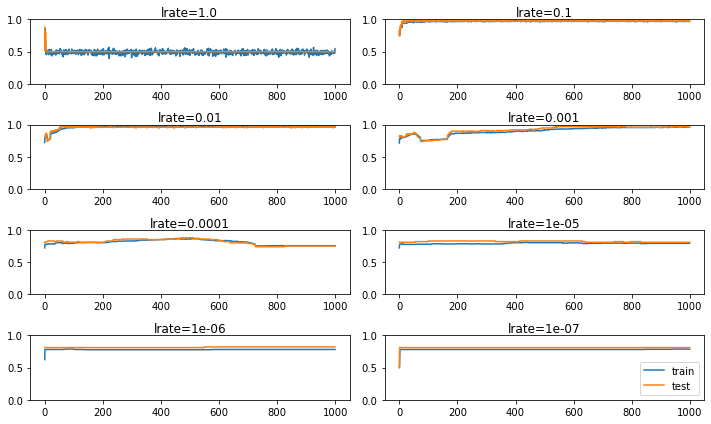

In [21]:
# create learning curves for different learning rates
learning_rates = [1E-0, 1E-1, 1E-2, 1E-3, 1E-4, 1E-5, 1E-6, 1E-7]

fig = plt.figure(figsize=(10, 6))

for i in range(len(learning_rates)):
	# determine the plot number
	plot_no = 420 + (i+1)
	fig.add_subplot(plot_no,ylim=(0,1))
	#plt.subplot(plot_no)
	# fit model and plot learning curves for a learning rate
	fit_model("lrate",train_x, train_y, test_x, test_y, learning_rates[i])
# show learning curves
plt.legend()
plt.tight_layout()
plt.show()

## 5.2 Effect of Momentum

Training: begins at 1598960791.7734203
Evaluating: ends at 32.471461057662964
Training: begins at 1598960824.3016725
Evaluating: ends at 33.95863366127014
Training: begins at 1598960858.3184674
Evaluating: ends at 32.61894869804382
Training: begins at 1598960890.9903066
Evaluating: ends at 32.861918449401855


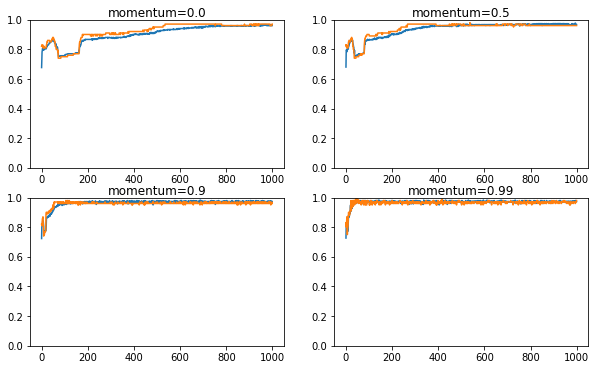

In [ ]:
# create learning curves for different momentums
momentums = [0.0, 0.5, 0.9, 0.99]

fig = plt.figure(figsize=(10, 6))

for i in range(len(momentums)):
    # determine the plot number
    plot_no = 220 + (i+1)
    fig.add_subplot(plot_no,ylim=(0,1))
    # fit model and plot learning curves for a momentum
    fit_model("momentum",train_x, train_y, test_x, test_y, lrate=0.01, momentum=momentums[i])
# show learning curves
plt.show()

## 5.3 Effect of Learning Rate Schedules

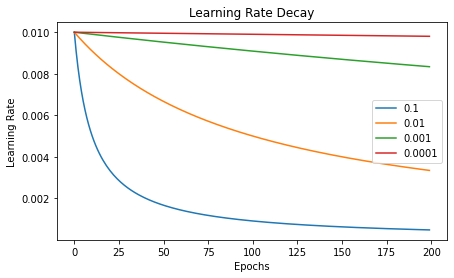

In [ ]:
# learning rate decay
def	decay_lrate(initial_lrate, decay, iteration):
	return initial_lrate * (1.0 / (1.0 + decay * iteration))

decays = [1E-1, 1E-2, 1E-3, 1E-4]
lrate = 0.01
n_updates = 200

for decay in decays:
	# calculate learning rates for updates
	lrates = [decay_lrate(lrate, decay, i) for i in range(n_updates)]
	# plot result
	plt.plot(lrates, label=str(decay))
plt.legend(loc="best")
plt.title("Learning Rate Decay")
plt.ylabel("Learning Rate")
plt.xlabel("Epochs")
plt.show()

Training: begins at 1598961088.9961185
Evaluating: ends at 32.52550220489502
Training: begins at 1598961121.5797973
Evaluating: ends at 32.66049528121948
Training: begins at 1598961154.29346
Evaluating: ends at 32.85230088233948
Training: begins at 1598961187.198824
Evaluating: ends at 32.61746025085449


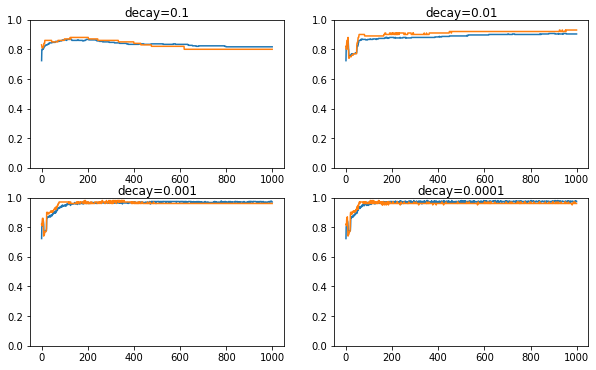

In [ ]:
# create learning curves for different decay rates
decay_rates = [1E-1, 1E-2, 1E-3, 1E-4]

fig = plt.figure(figsize=(10, 6))

for i in range(len(decay_rates)):
    # determine the plot number
    plot_no = 220 + (i+1)
    fig.add_subplot(plot_no,ylim=(0,1))
    # fit model and plot learning curves for a momentum
    fit_model("decay",train_x, train_y, test_x, test_y, lrate=0.01, momentum=0.9, decay=decay_rates[i])
# show learning curves
plt.show()

# References

- [Andrew Ng et al. Deep Learning Specialization. 2018](https://www.deeplearning.ai/program/deep-learning-specialization/)